# Compute Principal Component Analysis

This notebook computes a Principal Component Analysis on the molecular descriptors previously computed.

## Initialization

### Imports

In [1]:
%reload_ext autoreload
%autoreload 2

# standard
from pathlib import Path
import sys
import warnings
# plot
import seaborn as sns
from matplotlib import pyplot as plt
# data
import pandas as pd
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# dev
PROJECT_DIR = list(Path("..").absolute().parents)[1]
sys.path.append(str(PROJECT_DIR))
import utils as u
Path("../tmp").mkdir(exist_ok=True)

/home/gally/Software/anaconda3/envs/paper_michael/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Globals

In [2]:
# Dataset labels
label_inhouse = 'Pseudo-NPs'
label_drugbank = 'DrugBank'
label_chemblnp = 'ChEMBL-NP'
# input files
input_inhouse = '../tmp/internal_cpds_desc.tsv.gz'
input_drugbank = '../tmp/drugbank_desc.tsv.gz'
input_chemblnp = '../tmp/chembl_np_desc.tsv.gz'

## Load data

In [3]:
# pseudo-NPs
df_inhouse = u.read_tsv(input_inhouse).rename({'Compound_Id': 'id'}, axis=1)
df_inhouse['dataset'] = label_inhouse
print(f"Loaded {len(df_inhouse):,} records for inhouse")
# DrugBank
df_drugbank = u.read_tsv(input_drugbank).rename({'DATABASE_ID': 'id'}, axis=1)
df_drugbank['dataset'] = label_drugbank
print(f"Loaded {len(df_drugbank):,} records for drugbank")
# ChEMBL-NP
df_chemblnp = u.read_tsv(input_chemblnp).rename({'chembl_id': 'id'}, axis=1)
df_chemblnp['dataset'] = label_chemblnp
print(f"Loaded {len(df_chemblnp):,} records for chemblnp")
# concatenate all into a single DF
df = pd.concat([df_inhouse, df_drugbank, df_chemblnp], join='inner')
print(f"Concatenated data into a DataFrame of {len(df):,} records")

Loaded 168 records for inhouse
Loaded 7,472 records for drugbank
Loaded 30,655 records for chemblnp
Concatenated data into a DataFrame of 38,295 records


### Check if some datasets overlap

In [4]:
df_overlap = df.groupby('Smiles').filter(lambda x: len(x) > 1)
df_overlap[['dataset', 'id']].groupby('dataset').count()

,id
dataset,
ChEMBL-NP,615
DrugBank,615


There are 615 molecules that are present in both ChEMBL-NP and DrugBank datasets. This is not surprising since NPs can be drugs and should not require any curation.

## Compute PCA

In [5]:
# define features
annotations = ['id', 'Smiles', 'dataset']
labels = ['dataset', 'id']
features = [c for c in df.columns if c not in annotations]

# extract features and labels
x = df.loc[:, features].values
y = df.loc[:, labels].values

# normalize features
x = StandardScaler().fit_transform(x)

# run pca
model = PCA(n_components=3)
pc = model.fit_transform(x)
df_pc = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3'])
df_pc = df_pc.merge(df[labels], left_index=True, right_index=True).sort_values('dataset', ascending=True)
display(df_pc)

,PC1,PC2,PC3,dataset,id
11507,-3.264544,1.827016,-0.079126,ChEMBL-NP,CHEMBL491350
17886,-0.183247,2.186771,1.038524,ChEMBL-NP,CHEMBL1836143
17887,0.659959,-1.313535,-0.128790,ChEMBL-NP,CHEMBL1836144
17888,-0.698980,0.972900,1.131799,ChEMBL-NP,CHEMBL1165514
17889,0.788110,2.894640,-0.149784,ChEMBL-NP,CHEMBL1164376
...,...,...,...,...,...
78,-0.670004,-0.837300,2.075822,Pseudo-NPs,409713
77,-1.030374,-0.930730,2.167538,Pseudo-NPs,409712
76,-1.101034,-0.828855,2.163521,Pseudo-NPs,409709
89,-0.917166,-1.058517,2.239965,Pseudo-NPs,409677


### Plot Variance

/home/gally/Publications/Michael/github/code_manuscript/utils.py:808: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


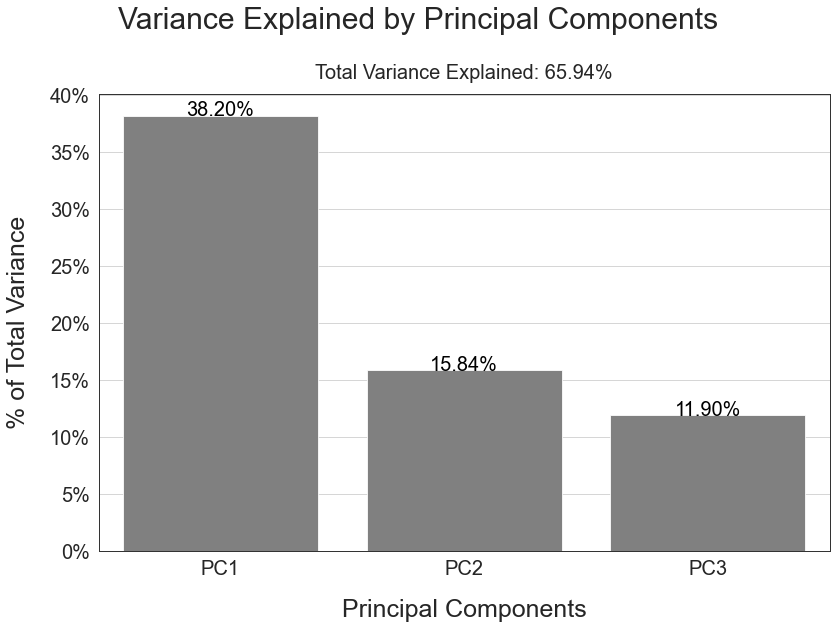

In [17]:
fig = u.plot_pc_var(model)
fig.savefig('pca_var.png', dpi=600)

By considering the first three PC, we can explain approx. 2/3 of the data variance. 

### Plot PCA

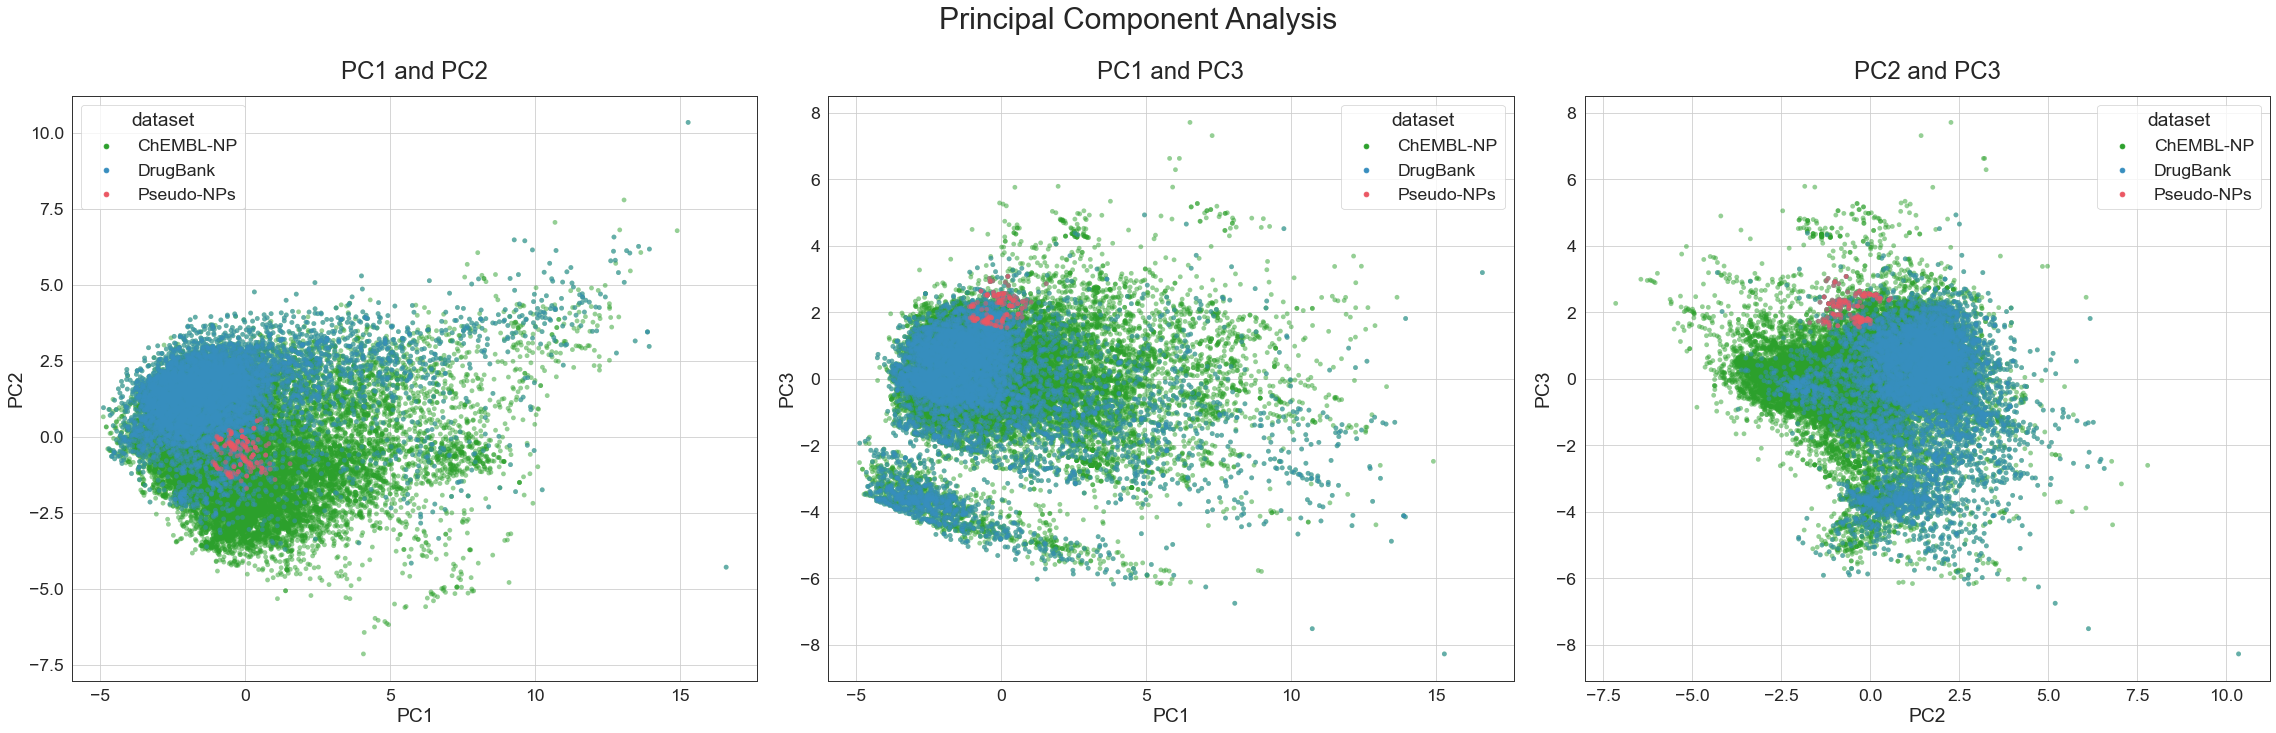

In [16]:
fig = u.plot_pc_proj(df_pc)
fig.savefig('pca_proj.png', dpi=300)  # file is too large with dpi=600

### Investigate feature contribution

In [8]:
df_pc_feature_contrib = u.get_pc_feature_contrib(model, features)
df_pc_feature_contrib

,Feature,PC1_feature_contrib,PC2_feature_contrib,PC3_feature_contrib,PC1_rank,PC2_rank,PC3_rank
0,frac_sp3,0.060140,0.414882,0.392124,15,2,3
1,molecular_weight,0.361897,0.145093,0.079695,1,10,12
2,num_atom_nitrogen,0.144798,0.289377,0.013225,12,6,16
3,num_atom_oxygen,0.326783,0.006355,0.021666,5,17,15
4,num_hba,0.358741,0.139669,0.013216,3,11,17
5,num_hbd,0.227922,0.257902,0.119880,8,7,9
6,num_heavy_atoms,0.359521,0.163142,0.102755,2,9,10
7,num_lipinski_violations,0.310668,0.075664,0.042255,6,15,14
8,num_rings,0.171720,0.311182,0.392996,10,5,2
9,num_rings_ali,0.124886,0.500405,0.080263,13,1,11


In [9]:
df_pc_feature_contrib = u.format_pc_feature_contrib(df_pc_feature_contrib)
display(df_pc_feature_contrib)
print("Most contributing features are:")
display(df_pc_feature_contrib[df_pc_feature_contrib['Rank'] == 1][['PC', 'Feature']].reset_index(drop=True))

,PC,Feature,Contribution,Rank
17,PC1,frac_sp3,0.060140,15
18,PC1,molecular_weight,0.361897,1
19,PC1,num_atom_nitrogen,0.144798,12
20,PC1,num_atom_oxygen,0.326783,5
21,PC1,num_hba,0.358741,3
22,PC1,num_hbd,0.227922,8
23,PC1,num_heavy_atoms,0.359521,2
24,PC1,num_lipinski_violations,0.310668,6
25,PC1,num_rings,0.171720,10
26,PC1,num_rings_ali,0.124886,13


Most contributing features are:


,PC,Feature
0,PC1,molecular_weight
1,PC2,num_rings_ali
2,PC3,num_rings_arom


/home/gally/Software/anaconda3/envs/paper_michael/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/home/gally/Software/anaconda3/envs/paper_michael/lib/python3.8/site-packages/seaborn/categorical.py:3737: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 2304x864 with 0 Axes>

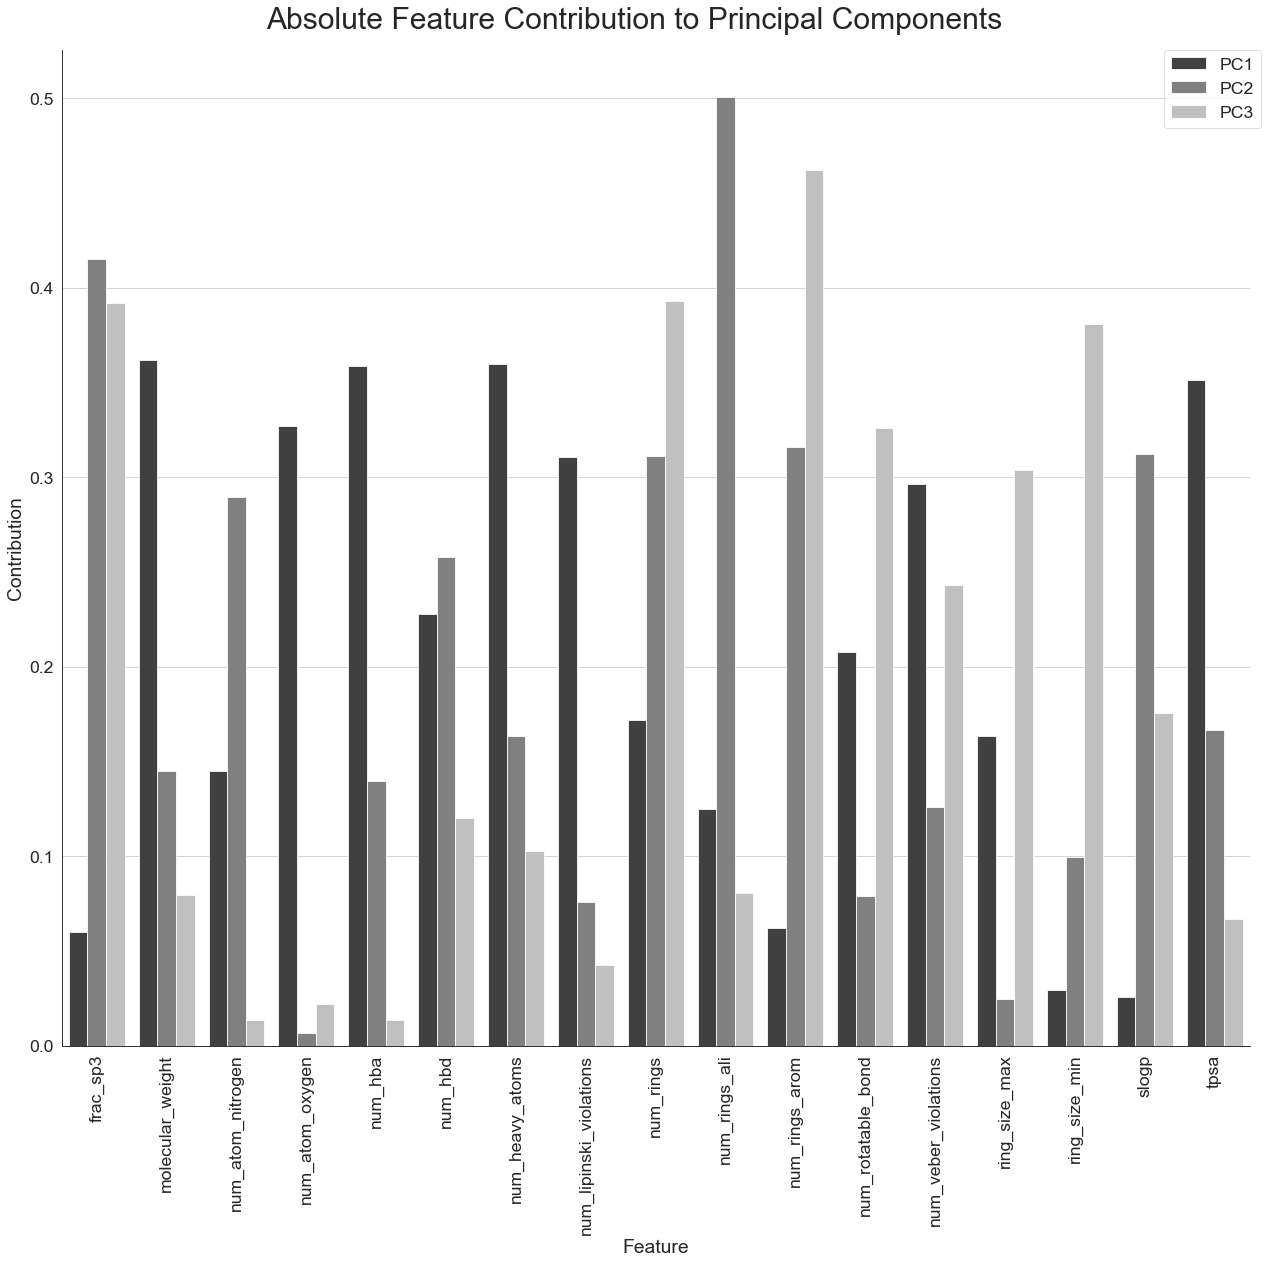

In [15]:
fig = u.plot_pc_feature_contrib(df_pc_feature_contrib)
fig.savefig('pca_feature_contrib.png', dpi=600)